In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import scipy as sp
import datetime as dt

from ei_net import * 
from ce_net import * 

from collections import Counter

%matplotlib inline

In [2]:
##########################################
############ PLOTTING SETUP ##############
EI_cmap = "Greys"
where_to_save_pngs = "../figs/pngs/"
where_to_save_pdfs = "../figs/pdfs/"
save = True
plt.rc('axes', axisbelow=True)
##########################################
##########################################

# The emergence of informative higher scales in complex networks

# Chapter 07: Effective Information Differences in Real Networks

The presence and informativeness of macroscales should vary across real networks, dependent on connectivity. Here we investigate the disposition toward causal emergence of real networks across different domains. We draw from the same set of networks analyzed in Chapter 04. The network sizes span up to 40,000 nodes, thus making it unfeasible to find the the best macroscales for each of them. Therefore, we focus specifically on the two categories that previously showed the greatest divergence in terms of the $EI$: biological and technological. Since we are interested in the general question of whether biological or technological networks show a greater disposition or propensity for causal emergence, we approximate causal emergence by calculating the causal emergence of sampled subgraphs of growing sizes. Each sample is found using a "snowball sampling" procedure, wherein a node is chosen randomly and then a weakly connected subgraph of a specified size is found around it. This subgraph is then analyzed using the previously described greedy algorithmic approach to find macro-nodes that maximized the $EI$ in each network. Each available network is sampled 20 times for each size taken from it. 

Here, we show how the causal emergence of these real networks differentiates as we increase the sampled subgraph size, in a sequence of 50, 100, 150, and finally 200 nodes per sample. Networks of these sizes previously provided ample  evidence of causal emergence in simulated networks. Comparing the two categories of real networks, we observe a significantly greater propensity for causal emergence in biological networks, and that this is more articulated the larger the samples are. Note that constructing a random null model of these networks (e.g., a configuration model) would tend to create networks with minimal or negligible causal emergence, as is the case for ER networks.

That subsets of biological systems show a high disposition toward causal emergence is consistent, and even explanatory, of many long-standing hypotheses surrounding the existence of noise and degeneracy in biological systems. It also explains the difficulty of understanding how the causal structure of biological systems function, since they are cryptic by containing certainty at one level and uncertainty at another.

________________________

## 7.1 Sampling subgraphs to estimate causal emergence

In [3]:
def snowball_sample(G, n_seeds=1, n_total=0.2, n_waves=5):
    """
    This function defines a procedure for "snowball sampling" a graph. The 
    algorithm starts from a (usually) single seed node, which it then expands
    outward from, collecting the nodes in waves around it in a "snowball" 
    manner.
    
    Params
    ------
    G (nx.Graph): the graph to be sampled.
    n_seeds (int): the number of seed nodes that the snowball sampling 
                   starts from.
    n_total (float): the fraction of the total size that will be sampled.
    n_waves (int): usually set high, this determines how many shells outward
                   the snowballing will continue.
    
    Returns
    -------
    (V_s, E_s) (list, list): the nodelist and edgelist of the sampled graph.
    
    """

    nodes = list(G.nodes())
    np.random.shuffle(nodes)
    n_total = int(len(nodes)*n_total)
    if n_total < 5: 
        n_total = 5
    
    V = [set()]*(n_waves+1)
    
    V_s = set()
    E_s = set()
    
    for k in range(n_waves+1):
        if k==0:
            V[k] = set(nodes[:n_seeds])
            nodes = set(nodes)
        else:
            for node_i in V[k-1]:
                for node_j in G.neighbors(node_i):
                    edge = (node_i,node_j) if node_i >= node_j else (node_j,node_i)
                    E_s.add(edge)
                    V[k].add(node_j)
                    if len(V_s.union(V[k].intersection(nodes-V_s))) > n_total:
                        V[k] = V[k].intersection(nodes-V_s)
                        V_s = V_s.union(V[k])
                        break
                        
            V[k] = V[k].intersection(nodes-V_s)

        V_s = V_s.union(V[k])
        
    E_s = list(E_s)
    return list(V_s), E_s

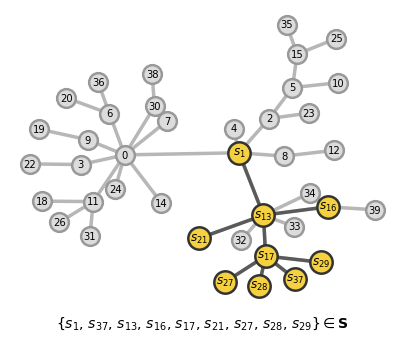

In [5]:
G = nx.barabasi_albert_graph(40,1)
samp,_ = snowball_sample(G,1)
Gs = G.subgraph(samp).copy()

mult=1.4
fig,ax=plt.subplots(1,1,figsize=(5*mult,4*mult))
pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G,pos=pos,iterations=1)
nx.draw_networkx_nodes(G,pos,node_color='gainsboro',node_size=350,
                       edgecolors='#999999',linewidths=2.5,ax=ax)
nx.draw_networkx_edges(G,pos,edge_color='#999999',alpha=0.7,width=3.5,ax=ax)
xxx = [i for i in G.nodes() if i not in samp]
labs = dict(zip(xxx,xxx))
nx.draw_networkx_labels(G,pos,labels=labs,ax=ax,font_size=10,zorder=0)

nodes = nx.draw_networkx_nodes(Gs,pos,node_color='#f5d13f',edgecolors='#333333',
                       node_size=500,linewidths=2.5,ax=ax)
edges = nx.draw_networkx_edges(Gs,pos,edge_color='#333333',alpha=0.7,width=3.5,ax=ax)

labs = dict(zip(Gs.nodes(),[r"$s_{%i}$"%i for i in Gs.nodes()]))
nx.draw_networkx_labels(Gs,pos,labels=labs,ax=ax,font_size=12)

titl = "{"+ ", ".join(list(labs.values()))+"}" + r"$\in \mathbf{S}$"
ax.set_title(titl,loc='center',pad=-320,fontsize=14)

ax.set_axis_off()

if save:
    plt.savefig(where_to_save_pngs+"Network_snowball.png", dpi=425, bbox_inches='tight')
    plt.savefig(where_to_save_pdfs+"Network_snowball.pdf", bbox_inches='tight')
plt.show()

__________________

## 7.2 Estimating Causal Emergence in Biological and Technological Networks

In [6]:
import json
json_data = open('../data/sampled_causalemergence.json',"r").read()
consolidata = json.loads(json_data)

In [7]:
type_mapping = {'brains':'Biological', 
                'citations':'Information', 
                'coauthorship':'Information', 
                'communication':'Social', 
                'computer':'Technological',
                'humancontact':'Social', 
                'humansocial':'Social', 
                'hyperlink':'Information', 
                'infrastructure':'Technological',
                'lexical':'Information', 
                'metabolic':'Biological', 
                'onlinesocial':'Social', 
                'power':'Technological', 
                'software':'Information',
                'technological':'Technological', 
                'trophic':'Biological'}

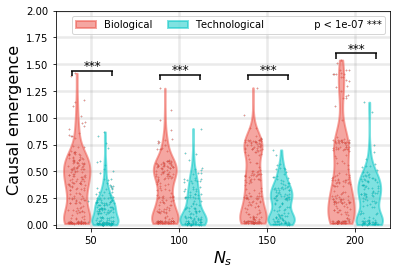

In [8]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
bio_noise = {50:[],100:[],150:[],200:[]}
tec_noise = {50:[],100:[],150:[],200:[]}
maxy = 0
for name,net in consolidata.items():
    col = net['Graph_Info']['Color']
    if "#" not in net['Graph_Info']['Color']:
        col = "#"+net['Graph_Info']['Color']
    
    
    net_type = type_mapping[net['Graph_Info']['Type']]
    yvals = net['CE']['CE']
    xvals = np.array(net['CE']['N_sample'])[:len(yvals)]
    if net_type=='Biological':
        if max(yvals)>maxy:
            maxy = max(yvals)
        for yi,y in enumerate(yvals):
            if y >= 0:
                if xvals[yi] > 40:
                    bio_noise[xvals[yi]].append(y)

        xvals = xvals + np.random.uniform(-13,-3,len(yvals))            
        ax.scatter(xvals, yvals, s=2, c=col,alpha=0.6,linewidths=0.15,edgecolors='k')

    if net_type=='Technological':
        if max(yvals)>maxy:
            maxy = max(yvals)
        for yi,y in enumerate(yvals):
            if y >= 0:
                if xvals[yi] > 40:
                    tec_noise[xvals[yi]].append(y)
        xvals = xvals + np.random.uniform(3,13,len(yvals))
        ax.scatter(xvals, yvals, s=2, c=col,alpha=0.6,linewidths=0.15,edgecolors='k')

plot_bio = [bio_noise[50], bio_noise[100], bio_noise[150], bio_noise[200]]
plot_tec = [tec_noise[50], tec_noise[100], tec_noise[150], tec_noise[200]]

parts = ax.violinplot(plot_bio, positions=[42, 92, 142, 192], 
                      showmeans=False, showmedians=False, 
                      showextrema=False, widths=15)
ll = 0
for i in range(len(parts['bodies'])):
    pc = parts['bodies'][i]
    pc.set_edgecolor("#ed4f44")
    pc.set_facecolor("#ed4f44")
    pc.set_alpha(0.5)
    pc.set_linewidth(2.0)
    ll += 1
    if ll==2:
        pc.set_label('Biological')

parts = ax.violinplot(plot_tec, positions=[58, 108, 158, 208], 
                      showmeans=False, showmedians=False, 
                      showextrema=False, widths=15)
ll = 0
for i in range(len(parts['bodies'])):
    pc = parts['bodies'][i]
    pc.set_edgecolor('#00c6c5')
    pc.set_facecolor('#00c6c5')
    pc.set_alpha(0.5)
    pc.set_linewidth(2.0)
    ll += 1
    if ll==2:
        pc.set_label('Technological')
        

ax.hlines(1.6,138.8+50,162.325+50,color='k')
ax.vlines(139.2+50,1.55,1.6,color='k')
ax.vlines(162+50,1.55,1.6,color='k')
ax.text(145.8+50,1.61,'***',fontsize=12)

ax.hlines(1.4,138.8,162.325,color='k')
ax.vlines(139.2,1.35,1.4,color='k')
ax.vlines(162,1.35,1.4,color='k')
ax.text(145.8,1.41,'***',fontsize=12)

ax.hlines(1.4,138.8-50,162.325-50,color='k')
ax.vlines(139.2-50,1.35,1.4,color='k')
ax.vlines(162-50,1.35,1.4,color='k')
ax.text(145.8-50,1.41,'***',fontsize=12)

ax.hlines(1.44,138.8-100,162.325-100,color='k')
ax.vlines(139.2-100,1.39,1.44,color='k')
ax.vlines(162-100,1.39,1.44,color='k')
ax.text(145.8-100,1.45,'***',fontsize=12)

ax.scatter(-1,-1,alpha=0,label='  p < 1e-07 ***')

ax.set_xticks([50,100,150,200])
ax.grid(linewidth=2.5, color='#999999', alpha=0.2, linestyle='-')

ax.set_xlim(30,220)
ax.set_ylim(-maxy*0.02,maxy*1.3)
ax.set_xlabel(r"$N_s$", fontsize=16)
ax.set_ylabel(r"Causal emergence", fontsize=16)

ax.legend(ncol=3,columnspacing=1.5)

if save:
    plt.savefig(where_to_save_pngs+"SamplingCE.png", dpi=425, bbox_inches='tight')
    plt.savefig(where_to_save_pdfs+"SamplingCE.pdf", bbox_inches='tight')

plt.show()

______________________

## End of Chapter 07. In [Chapter 08](https://nbviewer.jupyter.org/github/jkbren/einet/blob/master/code/Chapter%2008%20-%20Miscellaneous.ipynb) we'll wrap up final details about causal emergence.
_______________